## Install Required Libraries

In [ ]:
!pip install opencv-python-headless scipy
!pip install PyWavelets # Install the PyWavelets package which contains pywt
!pip install numpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 15.0 MB/s eta 0:00:00


## Upload an Image

In [ ]:
from google.colab import files
uploaded = files.upload()  # This will prompt you to upload an image.
image_path = list(uploaded.keys())[0]  # Get the filename of the uploaded image
print(f"Image uploaded: {image_path}")



Saving istockphoto-814423752-612x612.jpg to istockphoto-814423752-612x612.jpg
Image uploaded: istockphoto-814423752-612x612.jpg


## Load and Display the Image

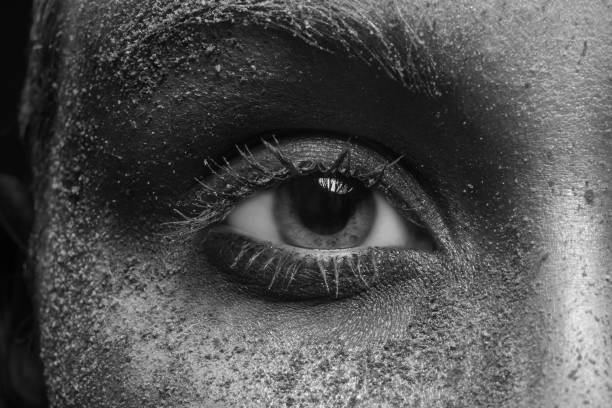

Original image displayed.


In [ ]:
import cv2
import numpy as np

# Load the image
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Check if the image loaded correctly
if image is None:
    raise ValueError("Error loading image!")

# Normalize the image to the range [0, 1]
image = np.float32(image) / 255.0

# Display the original image
from google.colab.patches import cv2_imshow
cv2_imshow((image * 255).astype('uint8'))  # Scale back to [0, 255] for display
print("Original image displayed.")


## Apply Discrete Cosine Transform (DCT)

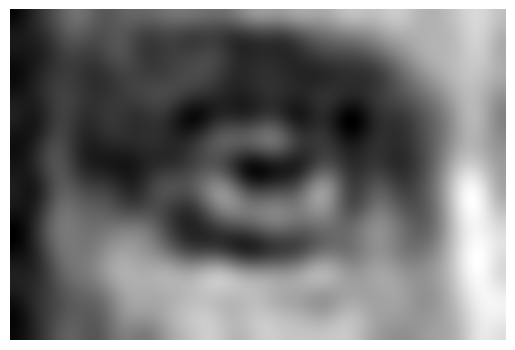

DCT-compressed image displayed.


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct

# Apply DCT
def apply_dct(image):
    return dct(dct(image.T, norm='ortho').T, norm='ortho')

# Apply inverse DCT
def apply_idct(dct_image):
    return idct(idct(dct_image.T, norm='ortho').T, norm='ortho')

# Compress the image using DCT
def compress_dct(image, threshold=10):
    dct_image = apply_dct(image)
    dct_image[np.abs(dct_image) < threshold] = 0  # Zero out small coefficients
    return dct_image

# Apply DCT compression
dct_image = compress_dct(image, threshold=2)

# Reconstruct image from DCT
dct_compressed = apply_idct(dct_image)

# Display the DCT-compressed image
plt.imshow(dct_compressed, cmap='gray')
plt.axis('off')
plt.show()

print("DCT-compressed image displayed.")


## Apply Walsh-Hadamard Transform

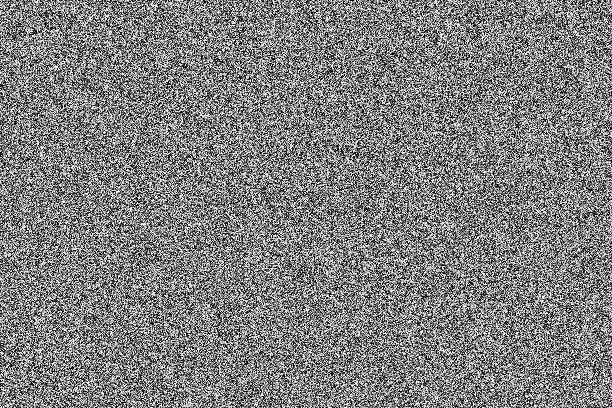

Walsh-Hadamard image displayed.


In [ ]:
from scipy.linalg import hadamard
import numpy as np

def apply_walsh_hadamard(image):
    """
    Apply the Walsh-Hadamard transform to an image.
    Reshape the image if dimensions are not powers of 2.
    """
    # Find the nearest power of 2 for rows and columns
    def next_power_of_2(x):
        return 1 if x == 0 else 2**(x - 1).bit_length()

    original_shape = image.shape
    new_rows = next_power_of_2(image.shape[0])
    new_cols = next_power_of_2(image.shape[1])

    # Resize the image to the nearest power of 2
    resized_image = cv2.resize(image, (new_cols, new_rows), interpolation=cv2.INTER_LINEAR)

    # Apply Walsh-Hadamard Transform
    hadamard_rows = hadamard(new_rows)
    hadamard_cols = hadamard(new_cols)

    transformed = hadamard_rows @ resized_image @ hadamard_cols.T

    # Resize back to original dimensions
    reshaped_transformed = cv2.resize(transformed, (original_shape[1], original_shape[0]), interpolation=cv2.INTER_LINEAR)

    return reshaped_transformed

# Apply the function
try:
    wh_image = apply_walsh_hadamard(image)
    cv2_imshow((wh_image * 255).astype('uint8'))
    print("Walsh-Hadamard image displayed.")
except Exception as e:
    print(f"Error: {e}")


## Apply Haar Wavelet Transform

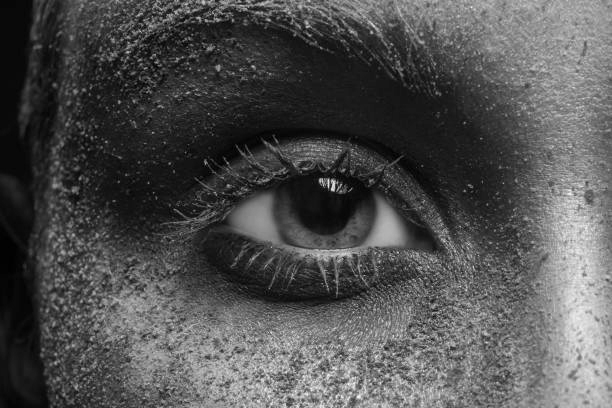

Haar-compressed image displayed.


In [ ]:
from pywt import wavedec2, waverec2

def apply_haar_transform(image, level=1):
    coeffs = wavedec2(image, 'haar', level=level)
    return coeffs

def reconstruct_haar(coeffs):
    return waverec2(coeffs, 'haar')

# Apply Haar transform and reconstruct
haar_coeffs = apply_haar_transform(image)
haar_compressed = reconstruct_haar(haar_coeffs)

cv2_imshow((haar_compressed * 255).astype('uint8'))
print("Haar-compressed image displayed.")


## Apply Principal Component Transform (PCT)

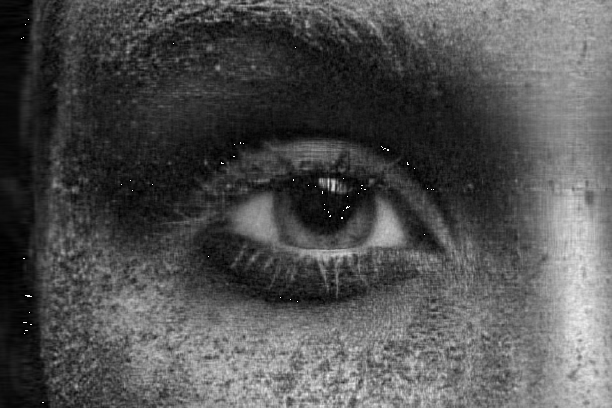

PCT-compressed image displayed.


In [ ]:
from sklearn.decomposition import PCA

def apply_pct(image, n_components=50):
    flat_image = image.reshape(-1, image.shape[1])  # Flatten for PCA
    pca = PCA(n_components=n_components)
    compressed = pca.fit_transform(flat_image)
    return pca, compressed

def reconstruct_pct(pca, compressed, original_shape):
    restored = pca.inverse_transform(compressed)
    return restored.reshape(original_shape)

# Apply PCT and reconstruct
pca, pct_compressed = apply_pct(image)
pct_restored = reconstruct_pct(pca, pct_compressed, image.shape)

cv2_imshow((pct_restored * 255).astype('uint8'))
print("PCT-compressed image displayed.")


## Apply Filtering

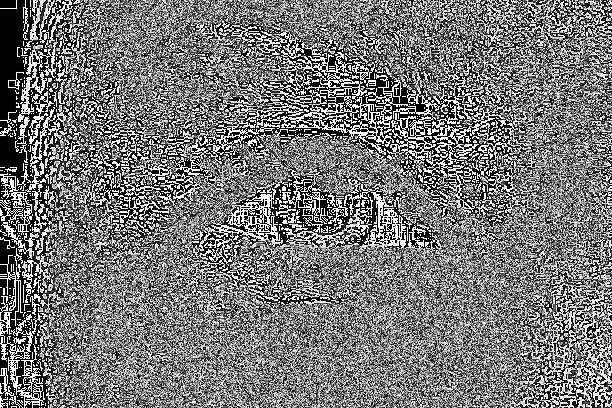

Filtered image displayed.


In [ ]:
def apply_filter(image, kernel):
    return cv2.filter2D(image, -1, kernel)

# Example high-pass filter kernel
kernel = np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]])

# Apply filter
filtered_image = apply_filter(image, kernel)
cv2_imshow((filtered_image * 255).astype('uint8'))
print("Filtered image displayed.")


## Evaluate Compression

In [ ]:
def evaluate_compression(original, compressed):
    # Calculate the compression ratio
    original_size = np.prod(original.shape)
    compressed_size = np.count_nonzero(compressed)
    compression_ratio = original_size / compressed_size

    # Evaluate visual quality using MSE and PSNR
    mse = np.mean((original - compressed) ** 2)
    psnr = cv2.PSNR(original, compressed)


    return compression_ratio, mse, psnr

# Assuming `image` is the original and `dct_image` is the compressed version
dct_ratio, mse, psnr = evaluate_compression(image, dct_image)
print(f"DCT Compression Ratio: {dct_ratio:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Peak Signal-to-Noise Ratio (PSNR): {psnr:.2f} dB")


DCT Compression Ratio: 2937.60
Mean Squared Error (MSE): 0.28
Peak Signal-to-Noise Ratio (PSNR): 53.67 dB
